In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils.load_data_for_eda import load_data
from utils.effect_sizes import compute_effect_sizes_by_group, compute_effect_sizes_by_commodity
df = load_data('data/commodity_prices.csv')
df = compute_effect_sizes_by_group(df)
df = compute_effect_sizes_by_commodity(df)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", None)

In [54]:
def compare_eta_omega(df, features = ['Commodity', 'Variety_Type', 'Season', 'Market', 'Year'], absolute_differnece_threshold=0.1, ratio_threshold=1.5):
    results = []
    for feature in features:    
        df[f'eta2-omega2_diff_{feature}'] = df[f'eta2_{feature}'] - df[f'omega2_{feature}']
        df[f'eta2/omega2_ratio_{feature}'] = df[f'eta2_{feature}'] / (df[f'omega2_{feature}'] + 1e-9)
        suspicious = df[(df[f'eta2-omega2_diff_{feature}'] > absolute_differnece_threshold) & (df[f'eta2/omega2_ratio_{feature}'] > ratio_threshold)].copy()
        suspicious['feature_flagged'] = feature
        results.append(suspicious)
    if results:
        suspicious_df = pd.concat(results)
    else:
        suspicious_df = pd.DataFrame()
    return suspicious_df

suspicious_df = compare_eta_omega(df)
drop_cols = ['Arrival_Date', 'Min_Price', 'Max_Price', 'Modal_Price']
suspicious_df.drop(columns=drop_cols, inplace=True)
suspicious_df = suspicious_df.drop_duplicates()
suspicious_df.head(20)

,Product_Type,Commodity,Variety_Type,Market,Is_VFPCK,Season,Year,eta2_Season,omega2_Season,eta2_Market,omega2_Market,eta2_Year,omega2_Year,eta2_Commodity,omega2_Commodity,eta2_Variety_Type,omega2_Variety_Type,eta2-omega2_diff_Commodity,eta2/omega2_ratio_Commodity,feature_flagged,eta2-omega2_diff_Variety_Type,eta2/omega2_ratio_Variety_Type,eta2-omega2_diff_Season,eta2/omega2_ratio_Season,eta2-omega2_diff_Market,eta2/omega2_ratio_Market,eta2-omega2_diff_Year,eta2/omega2_ratio_Year
36104,Banana|Poovan|Small,Banana,Banana|Poovan,Koovapadi VFPCK,True,Southwest Monsoon,2023,0.189078,0.064812,0.840855,0.789666,0.469398,0.408542,0.64585,0.645579,0.048591,0.048092,0.000271,1.00042,Season,0.000499,1.010371,0.124266,2.917344,NaN,NaN,NaN,NaN
36117,Banana|Poovan|Small,Banana,Banana|Poovan,Ernakulam,False,Post Monsoon,2023,0.189078,0.064812,0.840855,0.789666,0.469398,0.408542,0.64585,0.645579,0.048591,0.048092,0.000271,1.00042,Season,0.000499,1.010371,0.124266,2.917344,NaN,NaN,NaN,NaN
36118,Banana|Poovan|Small,Banana,Banana|Poovan,Moovattupuzha,False,Winter,2024,0.189078,0.064812,0.840855,0.789666,0.469398,0.408542,0.64585,0.645579,0.048591,0.048092,0.000271,1.00042,Season,0.000499,1.010371,0.124266,2.917344,NaN,NaN,NaN,NaN
36120,Banana|Poovan|Small,Banana,Banana|Poovan,Moovattupuzha,False,Summer,2024,0.189078,0.064812,0.840855,0.789666,0.469398,0.408542,0.64585,0.645579,0.048591,0.048092,0.000271,1.00042,Season,0.000499,1.010371,0.124266,2.917344,NaN,NaN,NaN,NaN
36121,Banana|Poovan|Small,Banana,Banana|Poovan,Thrippunithura,False,Winter,2024,0.189078,0.064812,0.840855,0.789666,0.469398,0.408542,0.64585,0.645579,0.048591,0.048092,0.000271,1.00042,Season,0.000499,1.010371,0.124266,2.917344,NaN,NaN,NaN,NaN
36122,Banana|Poovan|Small,Banana,Banana|Poovan,Thrippunithura,False,Summer,2025,0.189078,0.064812,0.840855,0.789666,0.469398,0.408542,0.64585,0.645579,0.048591,0.048092,0.000271,1.00042,Season,0.000499,1.010371,0.124266,2.917344,NaN,NaN,NaN,NaN
36123,Banana|Poovan|Small,Banana,Banana|Poovan,THURAVOOR VFPCK,True,Summer,2025,0.189078,0.064812,0.840855,0.789666,0.469398,0.408542,0.64585,0.645579,0.048591,0.048092,0.000271,1.00042,Season,0.000499,1.010371,0.124266,2.917344,NaN,NaN,NaN,NaN
36125,Banana|Poovan|Small,Banana,Banana|Poovan,Thrippunithura,False,Southwest Monsoon,2025,0.189078,0.064812,0.840855,0.789666,0.469398,0.408542,0.64585,0.645579,0.048591,0.048092,0.000271,1.00042,Season,0.000499,1.010371,0.124266,2.917344,NaN,NaN,NaN,NaN
36127,Banana|Poovan|Small,Banana,Banana|Poovan,KANJOOR VFPCK,True,Southwest Monsoon,2025,0.189078,0.064812,0.840855,0.789666,0.469398,0.408542,0.64585,0.645579,0.048591,0.048092,0.000271,1.00042,Season,0.000499,1.010371,0.124266,2.917344,NaN,NaN,NaN,NaN
38504,Banana|Robusta|Small,Banana,Banana|Robusta,Koovapadi VFPCK,True,Southwest Monsoon,2023,0.086343,0.019790,0.368355,0.199920,0.360362,0.249671,0.64585,0.645579,0.028179,0.027355,0.000271,1.00042,Market,0.000825,1.030149,0.066553,4.362889,0.168435,1.84251,NaN,NaN


Context:
We compared η² (eta squared) and ω² (omega squared) to evaluate the influence of features on commodity price variation.

Observations from the output:
	•	Some features, like Season in Banana|Poovan|Small, have high η² but much lower ω² → indicates inflated effect size.
	•	Other features, like Market in Banana|Robusta|Small, also show discrepancies between η² and ω².
	•	Rows flagged in feature_flagged correspond to features where η² may be overestimating the true effect.

Approach moving forward:
	•	Use both η² and ω² to define “important features.”
	•	η² threshold = 0.05 (capture observed influence)
	•	ω² threshold = 0.02 (filter out likely noise)
	•	This ensures robust grouping, capturing real influential features while avoiding noise-driven false positives.

In [55]:
def important_features(row, threshold_eta=0.05, threshold_omega=0.02):
    features = []
    for col in ['Commodity','Variety_Type','Season','Market','Year']:
        if (row[f'eta2_{col}'] >= threshold_eta) & (row[f'omega2_{col}'] >= threshold_omega):
            features.append(col)
    if not features:
        return 'None'
    else:
        return '|'.join(features) 

df['important_features'] = df.apply(important_features, axis=1)

In [56]:
df_grouped = df.groupby(['important_features', 'Product_Type', 'Market']).agg(
    Mean_Commodity_Effect_Size=('eta2_Commodity', 'mean'),
    Mean_Variety_Type_Effect_Size=('eta2_Variety_Type', 'mean'),
    Mean_Season_Effect_Size=('eta2_Season', 'mean'),
    Mean_Market_Effect_Size=('eta2_Market', 'mean'),
    Mean_Year_Effect_Size=('eta2_Year', 'mean'),
    Total_Records=('Product_Type', 'count')
).reset_index()
df_grouped.head(20)


,important_features,Product_Type,Market,Mean_Commodity_Effect_Size,Mean_Variety_Type_Effect_Size,Mean_Season_Effect_Size,Mean_Market_Effect_Size,Mean_Year_Effect_Size,Total_Records
0,Commodity,Capsicum|Other|FAQ,Piravam,0.057064,0.0,0.031460,0.000000,0.008407,502
1,Commodity|Market,Amaranthus|Amaranthus|FAQ,Aluva,0.149755,0.0,0.012293,0.746367,0.013385,587
2,Commodity|Market,Amaranthus|Amaranthus|FAQ,Angamaly,0.149755,0.0,0.012293,0.746367,0.013385,570
3,Commodity|Market,Amaranthus|Amaranthus|FAQ,Broadway market,0.149755,0.0,0.012293,0.746367,0.013385,394
4,Commodity|Market,Amaranthus|Amaranthus|FAQ,Ernakulam,0.149755,0.0,0.012293,0.746367,0.013385,518
5,Commodity|Market,Amaranthus|Amaranthus|FAQ,Keezhampara VFPCK,0.149755,0.0,0.012293,0.746367,0.013385,9
6,Commodity|Market,Amaranthus|Amaranthus|FAQ,North Paravur,0.149755,0.0,0.012293,0.746367,0.013385,452
7,Commodity|Market,Amaranthus|Amaranthus|FAQ,Perumbavoor,0.149755,0.0,0.012293,0.746367,0.013385,647
8,Commodity|Market,Cucumbar(Kheera)|Cucumbar|FAQ,Aluva,0.083959,0.0,0.049458,0.440824,0.037294,606
9,Commodity|Market,Cucumbar(Kheera)|Cucumbar|FAQ,Broadway market,0.083959,0.0,0.049458,0.440824,0.037294,415


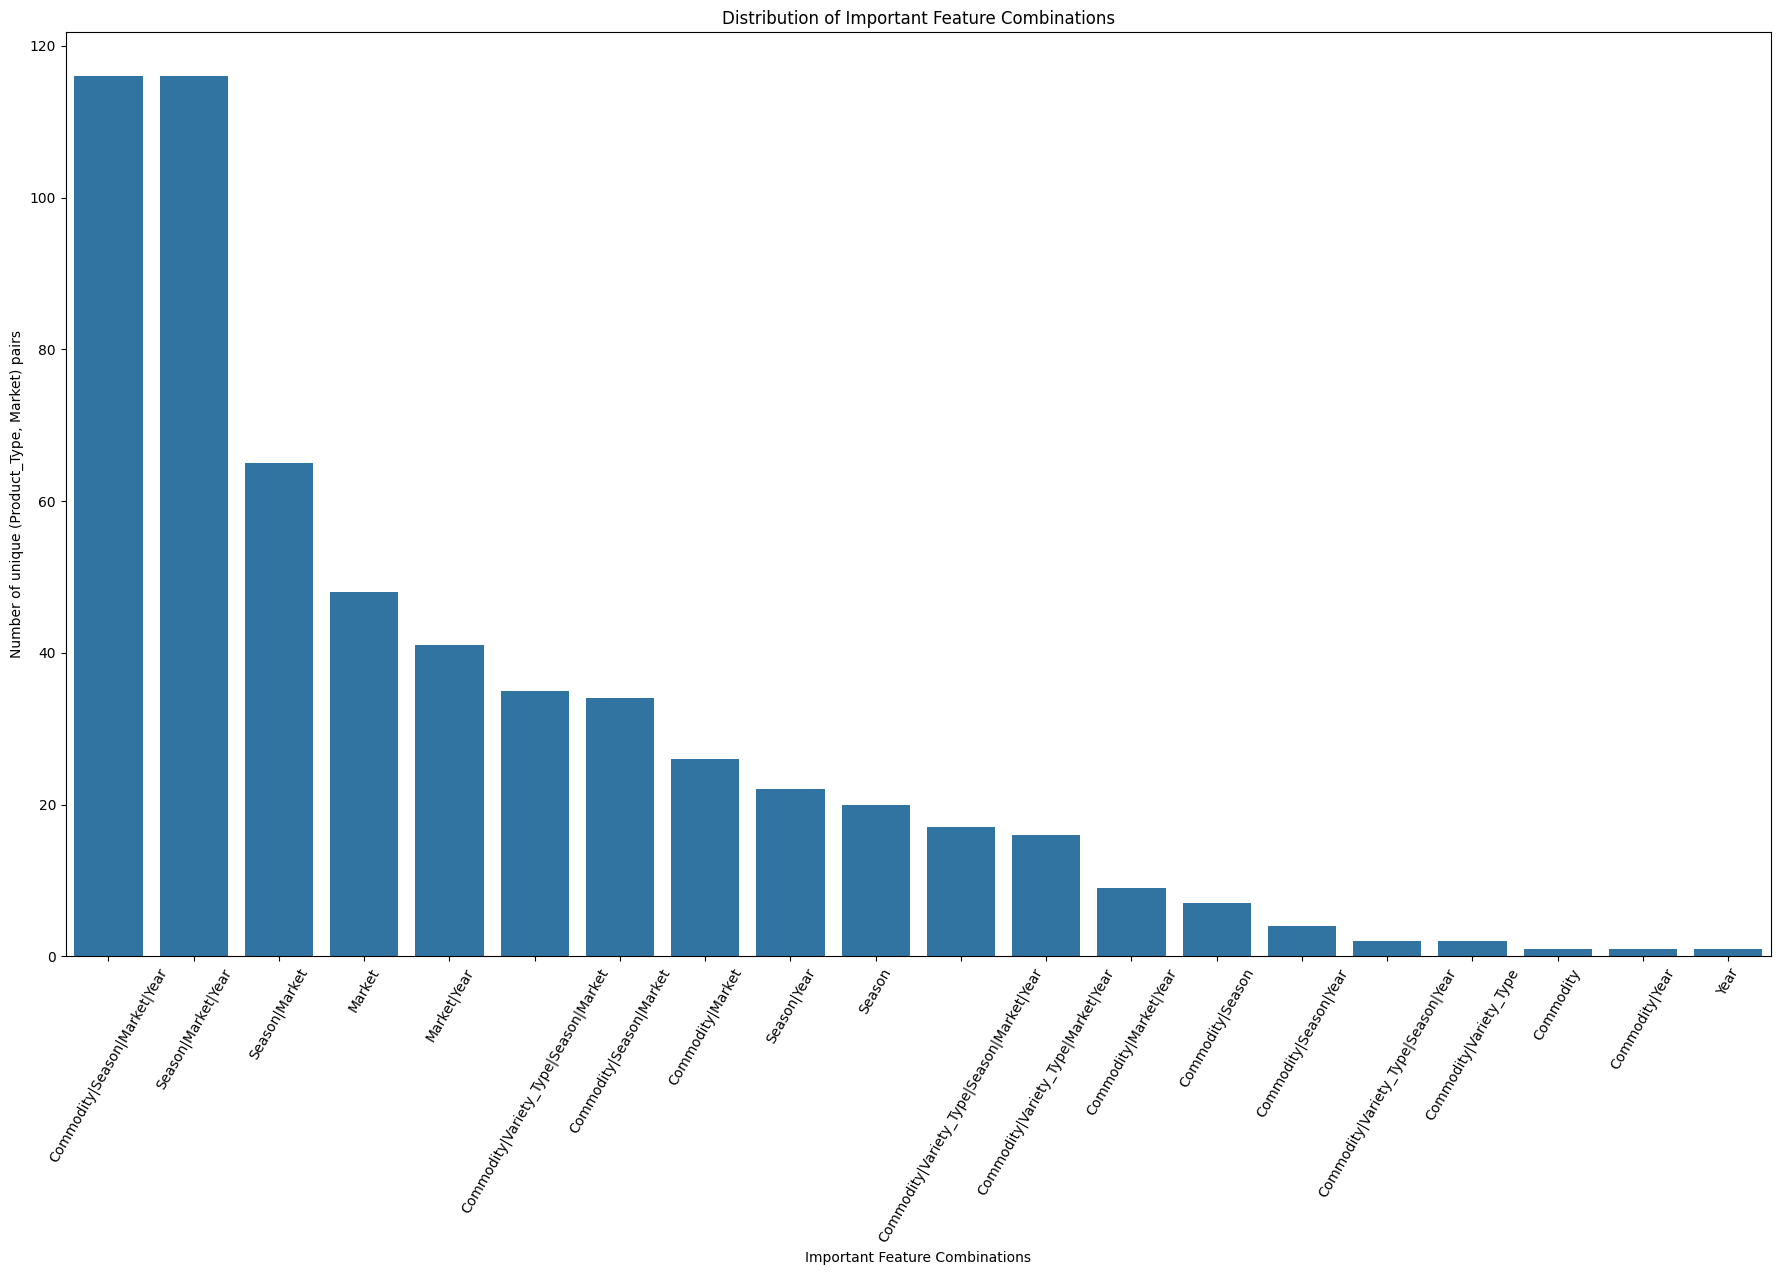

In [57]:
group_counts = df_grouped['important_features'].value_counts().reset_index()
fig, ax = plt.subplots(figsize=(22, 12))
sns.barplot(data=group_counts, x='important_features', y='count', ax=ax)
ax.set_title('Distribution of Important Feature Combinations')
ax.set_xlabel('Important Feature Combinations')
ax.set_ylabel('Number of unique (Product_Type, Market) pairs')
plt.xticks(rotation=60)
plt.show()  

Distribution of Total Records per (Product_Type, Market) pair

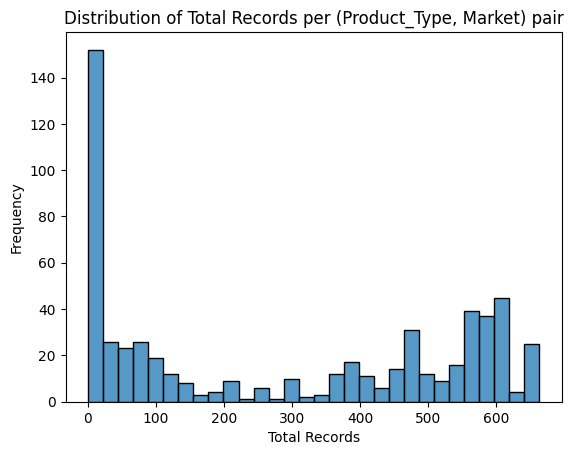

In [58]:
sns.histplot(df_grouped['Total_Records'], bins=30)
plt.title('Distribution of Total Records per (Product_Type, Market) pair')
plt.xlabel('Total Records')
plt.ylabel('Frequency')
plt.show()  

In [59]:
group_counts

,important_features,count
0,Commodity|Season|Market|Year,116
1,Season|Market|Year,116
2,Season|Market,65
3,Market,48
4,Market|Year,41
5,Commodity|Variety_Type|Season|Market,35
6,Commodity|Season|Market,34
7,Commodity|Market,26
8,Season|Year,22
9,Season,20


Mean Effect Sizes by Important Feature Combinations

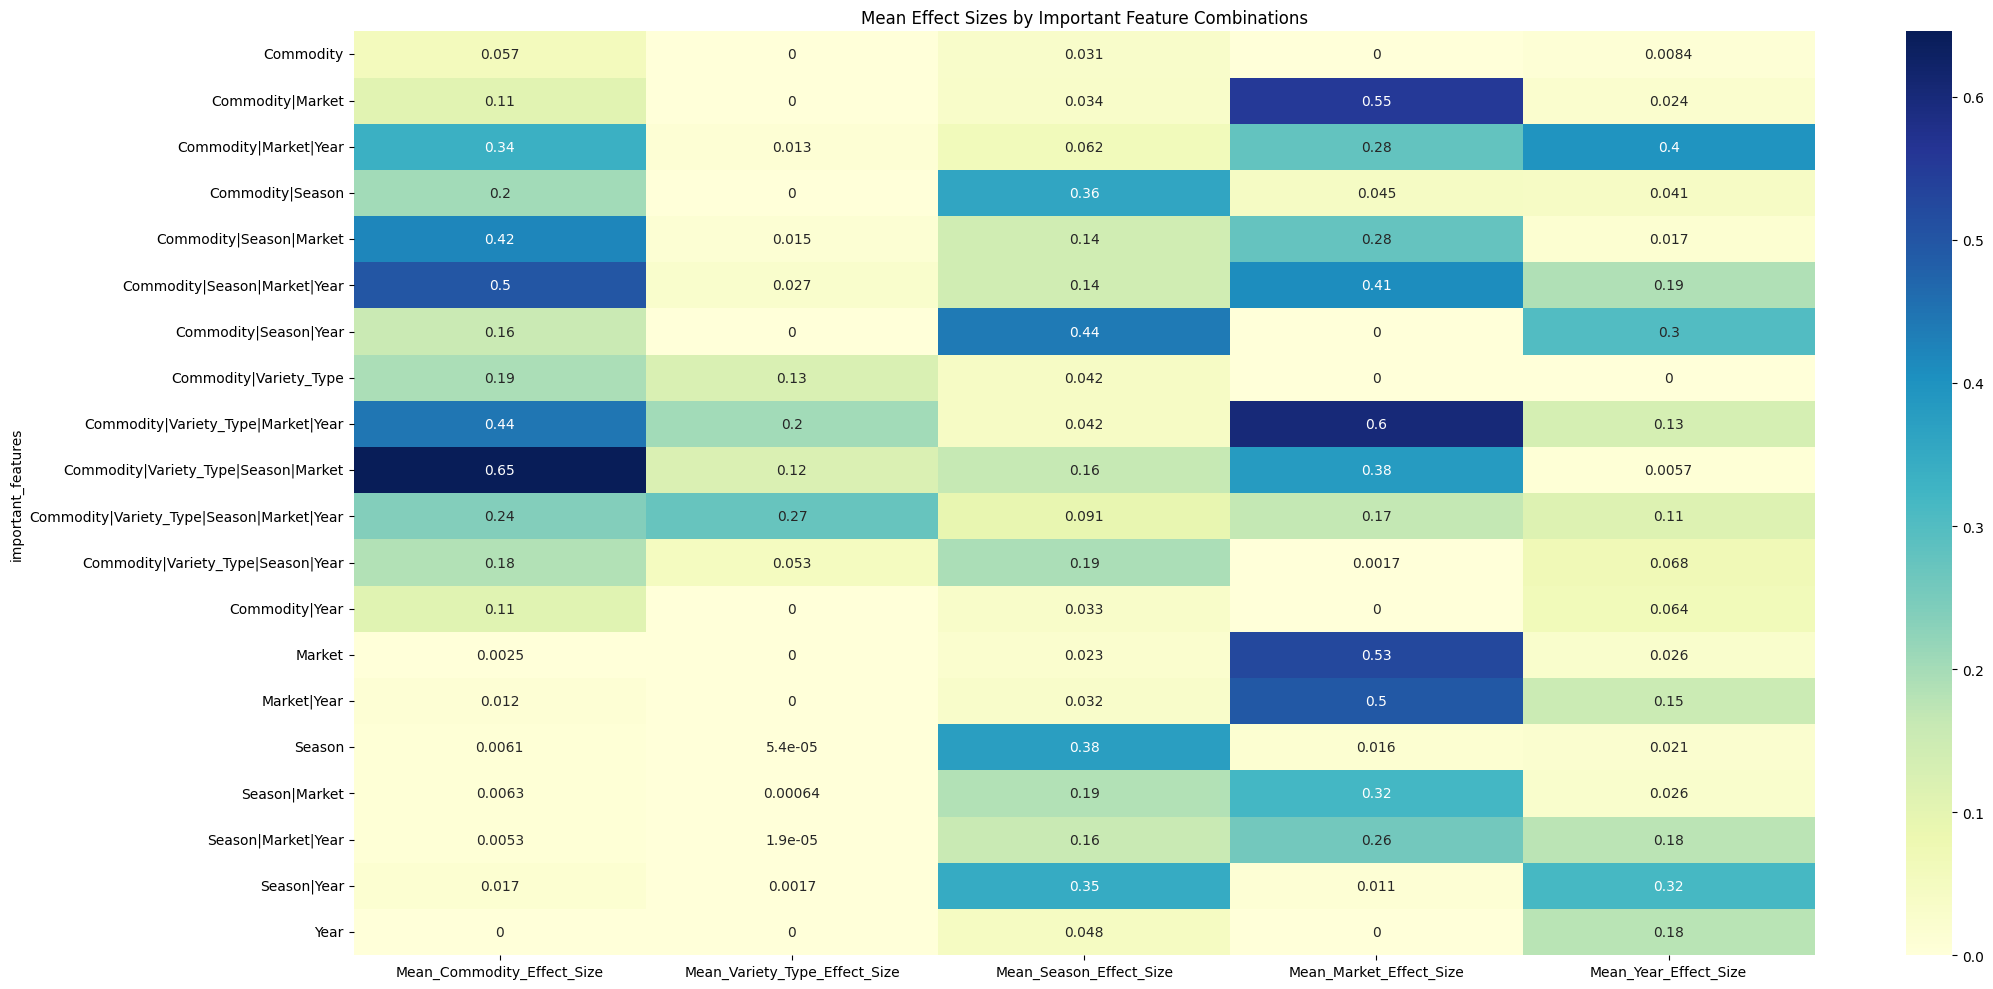

In [61]:
# Aggregate mean by important_features
heatmap_data = df_grouped.groupby('important_features')[
    ['Mean_Commodity_Effect_Size', 'Mean_Variety_Type_Effect_Size', 
     'Mean_Season_Effect_Size', 'Mean_Market_Effect_Size', 'Mean_Year_Effect_Size']
].mean()

# Plot heatmap
fig, ax = plt.subplots(figsize=(22, 10))
sns.heatmap(data=heatmap_data, annot=True, cmap='YlGnBu', ax=ax)
ax.set_title('Mean Effect Sizes by Important Feature Combinations')
plt.tight_layout()
plt.show()

In [62]:
data = df_grouped[
    ['Mean_Commodity_Effect_Size', 'Mean_Variety_Type_Effect_Size', 
     'Mean_Season_Effect_Size', 'Mean_Market_Effect_Size', 'Mean_Year_Effect_Size']
].set_index(df_grouped['important_features']).drop_duplicates()

data.head(20)

,Mean_Commodity_Effect_Size,Mean_Variety_Type_Effect_Size,Mean_Season_Effect_Size,Mean_Market_Effect_Size,Mean_Year_Effect_Size
important_features,,,,,
Commodity,0.057064,0.000000,0.031460,0.000000,0.008407
Commodity|Market,0.149755,0.000000,0.012293,0.746367,0.013385
Commodity|Market,0.149755,0.000000,0.012293,0.746367,0.013385
Commodity|Market,0.083959,0.000000,0.049458,0.440824,0.037294
Commodity|Market,0.083959,0.000000,0.049458,0.440824,0.037294
Commodity|Market,0.083959,0.000000,0.049458,0.440824,0.037294
Commodity|Market,0.083959,0.000000,0.049458,0.440824,0.037294
Commodity|Market,0.083959,0.000000,0.049458,0.440824,0.037294
Commodity|Market,0.083959,0.000000,0.031242,0.721173,0.006402


In [ ]:
df_grouped[['important_features', 'Product_Types']]

In [3]:
df[df['eta2_Commodity'] >= 0.1][['Product_Type', 'eta2_Commodity', 'omega2_Commodity']].drop_duplicates()

,Product_Type,eta2_Commodity,omega2_Commodity
471,Amaranthus|Amaranthus|FAQ,0.149755,0.149530
3648,Amaranthus|Other|FAQ,0.149755,0.149530
20696,Banana|Nendra Bale|Large,0.645850,0.645579
25696,Banana|Nendra Bale|Medium,0.645850,0.645579
25837,Banana|Nendra Bale|Small,0.645850,0.645579
25870,Banana|Other|Large,0.645850,0.645579
25945,Banana|Other|Medium,0.645850,0.645579
26028,Banana|Palayamthodan|Large,0.645850,0.645579
29555,Banana|Palayamthodan|Medium,0.645850,0.645579
32172,Banana|Palayamthodan|Small,0.645850,0.645579


In [4]:
df[df['eta2_Variety_Type'] >= 0.1][['Product_Type', 'eta2_Variety_Type', 'omega2_Variety_Type']].drop_duplicates()

,Product_Type,eta2_Variety_Type,omega2_Variety_Type
26028,Banana|Palayamthodan|Large,0.123560,0.123260
29555,Banana|Palayamthodan|Medium,0.123560,0.123260
32172,Banana|Palayamthodan|Small,0.123560,0.123260
126416,Onion|1st Sort|FAQ,0.199267,0.198114
127142,Onion|1st Sort|Non-FAQ,0.199267,0.198114
132863,Pineapple|Other|Large,0.284891,0.284471
134808,Pineapple|Other|Medium,0.284891,0.284471
136209,Pineapple|Other|Small,0.284891,0.284471


“While market, season, and year effects dominate overall, certain commodities (notably Banana, Pineapple, Onion) show strong within-commodity variety-level effects. This justifies treating Commodity and Variety as important features in price modeling.”

In [6]:
threshold = 0.05  # meaning feature explains <5% of variance, consider it negligible
df_basic = df[(df['eta2_Commodity'] < threshold) & 
              (df['eta2_Variety_Type'] < threshold) &
              (df['eta2_Season'] < threshold) &
              (df['eta2_Market'] < threshold) &
              (df['eta2_Year'] < threshold)]
df_basic

,Product_Type,Commodity,Variety_Type,Arrival_Date,Market,Is_VFPCK,Season,Year,Modal_Price,Max_Price,...,eta2_Season,omega2_Season,eta2_Market,omega2_Market,eta2_Year,omega2_Year,eta2_Commodity,omega2_Commodity,eta2_Variety_Type,omega2_Variety_Type


In [13]:
df_simple = df[(df['eta2_Market'] == 0.0) & (df['eta2_Year'] == 0.0)]

In [30]:
df[df['Product_Type'].str.contains('Coriander')]['Product_Type'].value_counts()

Product_Type
Coriander(Leaves)|Coriander|FAQ    449
Coriander(Leaves)|Other|FAQ        151
Name: count, dtype: int64

In [33]:
df[df['Product_Type'] == 'Coriander(Leaves)|Coriander|FAQ']['Season'].value_counts()

Season
Summer               142
Southwest Monsoon    129
Winter               108
Post Monsoon          70
Name: count, dtype: int64

In [32]:
df[df['Product_Type'] == 'Coriander(Leaves)|Other|FAQ']['Market'].value_counts()

Market
Piravam    151
Name: count, dtype: int64

In [16]:
df_simple['Product_Type'].value_counts()

Product_Type
Coriander(Leaves)|Other|FAQ      151
Orange|Other|Large               149
Sweet Potato|Other|FAQ           140
Tomato|Deshi|Non-FAQ             122
Water Melon|Water Melon|Large    119
Onion|1st Sort|Non-FAQ           108
Potato|(Red Nanital)|Non-FAQ     108
Long Melon(Kakri)|Other|FAQ       98
Egg|Egg|FAQ                       26
Name: count, dtype: int64

In [26]:
df_simple[['Product_Type', 'eta2_Season', 'omega2_Season']].drop_duplicates()

,Product_Type,eta2_Season,omega2_Season
83938,Coriander(Leaves)|Other|FAQ,0.175735,0.163685
97951,Egg|Egg|FAQ,0.500000,0.446809
122165,Long Melon(Kakri)|Other|FAQ,0.234177,0.216311
127142,Onion|1st Sort|Non-FAQ,0.035741,0.017216
131281,Orange|Other|Large,0.534722,0.526670
141142,Potato|(Red Nanital)|Non-FAQ,0.047642,0.029236
156151,Sweet Potato|Other|FAQ,0.359891,0.348916
163816,Tomato|Deshi|Non-FAQ,0.604214,0.595581
167831,Water Melon|Water Melon|Large,0.100681,0.084521


In [4]:
df['eta2_Market'].nunique(), df['omega2_Market'].nunique(), df['eta2_Season'].nunique(), df['omega2_Season'].nunique(), df['eta2_Year'].nunique(), df['omega2_Year'].nunique(), df['eta2_Commodity'].nunique(), df['omega2_Commodity'].nunique()

(98, 98, 124, 124, 112, 112, 1, 1)